CS 171 Sec 4 Group Project

Tanya Gupta, Nhat Le, Tyler Nguyen


In [ ]:
#initialize needed libraries
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn import linear_model, metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import KFold, ShuffleSplit, StratifiedKFold, StratifiedShuffleSplit, TimeSeriesSplit
warnings.filterwarnings("ignore")

In [ ]:
#function that will be used to output MSE, MAE, RMSE, MAPE, and R2
def timeseries_evaluation_metrics_func(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [ ]:
#initialize the mid-tier San Jose Homes' Values
df = pd.read_csv("midTierAllHomes.csv")
df=df.iloc[:,:-1]
df.head(5)

,RegionID,SizeRank,RegionName,RegionType,StateName,1996-01-31,1996-02-29,1996-03-31,1996-04-30,1996-05-31,...,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30
0,102001,0,United States,country,NaN,109265.180383,109095.676695,109155.569885,109363.554893,109612.520655,...,329257.345037,334114.619841,339943.862979,346018.233702,352528.818505,356754.830595,359526.260243,359158.102261,358023.786647,358091.378335
1,394913,1,"New York, NY",msa,NY,188625.267307,186907.738371,186522.213709,186206.002046,186097.935571,...,578121.445900,583133.856863,588755.030374,598934.287161,607910.065648,615702.062132,619968.688450,621554.903213,620482.991765,619756.263314
2,753899,2,"Los Angeles, CA",msa,CA,187535.806762,186864.880014,186572.180966,186548.431121,186416.976291,...,878890.919332,892162.981058,906481.839475,935662.296589,955154.827578,960211.478267,937913.189174,934000.527320,902599.962352,897593.360077
3,394463,3,"Chicago, IL",msa,IL,147099.700804,147098.923393,146179.663686,147598.866028,148127.466534,...,291518.655071,294329.692123,298176.812923,303576.875998,308294.433566,313516.107710,314566.424412,313662.039722,312065.281120,311983.462353
4,394514,4,"Dallas, TX",msa,TX,113009.443351,112925.248113,113244.783251,113772.145381,114010.945821,...,350336.404616,359008.229625,369556.124915,375611.161083,390748.944050,398646.529571,400284.009721,395943.534446,390452.276608,389048.558123


In [ ]:
#Extract San Jose row from dataset since we will only be looking at San Jose Data
data = df[df['RegionName'] == "San Jose, CA"]
data = data.drop(['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName'], axis=1)
data = data.T


In [ ]:
#Clean the data
data.fillna(method='ffill',axis=0, inplace=True)
data.isnull().sum(axis=0)

35    0
dtype: int64

In [ ]:
#convert DataFrame to Series
data.index = pd.to_datetime(data.index)
data.index = data.index.strftime('%Y-%m')
data.index = pd.to_datetime(data.index)
data = data.squeeze()
data



1996-01-01    2.768736e+05
1996-02-01    2.747614e+05
1996-03-01    2.750380e+05
1996-04-01    2.746552e+05
1996-05-01    2.762244e+05
                  ...     
2022-05-01    1.669859e+06
2022-06-01    1.598279e+06
2022-07-01    1.525826e+06
2022-08-01    1.493071e+06
2022-09-01    1.493071e+06
Name: 35, Length: 321, dtype: float64

In [ ]:
#extract data from other data source for unemployment rates, convert to series, and also adjust dates so it lines up with House price data
df2 = pd.read_csv("unemploymentRateSJ.csv", parse_dates=True)
df2.rename(columns = {'SANJ906URN':'SJUnemployment_Rate'}, inplace = True)
df2 = df2[72:]
df2['DATE'] = pd.to_datetime(df2.DATE)
df2['DATE'] = df2['DATE'].dt.strftime('%Y-%m')
df2['DATE'] = pd.to_datetime(df2.DATE)
df2.set_index('DATE', inplace=True)
print(df2.isnull().sum(axis=0))
unemploy_data = df2.squeeze()
unemploy_data.head(5)


SJUnemployment_Rate    0
dtype: int64


DATE
1996-01-01    4.5
1996-02-01    4.3
1996-03-01    4.2
1996-04-01    4.0
1996-05-01    3.9
Name: SJUnemployment_Rate, dtype: float64

In [ ]:
#get interest rate data, reformat date time, clean data, convert to Series
!pip install --upgrade xlrd
interest_data = pd.read_excel("30yr_pmmsmnth.xls", sheet_name="Data")
interest_data.head(5)
interest_data['Date'] = pd.to_datetime(interest_data.Date)
interest_data['Date'] = interest_data['Date'].dt.strftime('%Y-%m')
interest_data['Date'] = pd.to_datetime(interest_data.Date)
interest_data.set_index('Date', inplace=True)
interest_data.isnull().sum(axis=0)
interest_data = interest_data.squeeze()
interest_data.head(5)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Date
1996-01-01    7.030
1996-02-01    7.075
1996-03-01    7.624
1996-04-01    7.925
1996-05-01    8.070
Name: Interest_rate, dtype: float64

In [ ]:
#extract US data for exogenous variable
dataUS = df[df['RegionName'] == "United States"]
dataUS = dataUS.drop(['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName'], axis=1)
dataUS = dataUS.T
#convert DataFrame to Series
dataUS.index = pd.to_datetime(dataUS.index)
dataUS.index = dataUS.index.strftime('%Y-%m')
dataUS.index = pd.to_datetime(dataUS.index)
dataUS = dataUS.squeeze()
dataUS


1996-01-01    109265.180383
1996-02-01    109095.676695
1996-03-01    109155.569885
1996-04-01    109363.554893
1996-05-01    109612.520655
                  ...      
2022-05-01    356754.830595
2022-06-01    359526.260243
2022-07-01    359158.102261
2022-08-01    358023.786647
2022-09-01    358091.378335
Name: 0, Length: 321, dtype: float64

In [ ]:
#Time Series' Version of cross validating the data for each split
tscv = TimeSeriesSplit()
print(tscv)
TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)
for train_index, test_index in tscv.split(data):
  print("TRAIN:", train_index, "TEST:", test_index)


TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55] TEST: [ 56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73
  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108]
TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108] TEST: [109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 1

In [ ]:
#prove the data is non-stationary or stationary
def adfuller_test(data):
  stats = adfuller(data, autolag='AIC')
  dfoutput = pd.Series(stats[0:4], index=['Test Statistic','p-value','No Lags Used','Number of Observations Used'])
  for key,value in stats[4].items():
      dfoutput['Critical Value (%s)'%key] = value
  print (dfoutput)
  if stats[1] <= 0.05:
      print("Conclusion:====>")
      print("Reject the null hypothesis")
      print("Data is stationary")
  else:
      print("Conclusion:====>")
      print("Fail to reject the null hypothesis")
      print("Data is non-stationary")

adfuller_test(data)
adfuller_test(dataUS)
adfuller_test(interest_data)
adfuller_test(unemploy_data)

Test Statistic                  -0.040607
p-value                          0.955042
No Lags Used                    12.000000
Number of Observations Used    308.000000
Critical Value (1%)             -3.451761
Critical Value (5%)             -2.870970
Critical Value (10%)            -2.571794
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary
Test Statistic                   0.326517
p-value                          0.978529
No Lags Used                    12.000000
Number of Observations Used    308.000000
Critical Value (1%)             -3.451761
Critical Value (5%)             -2.870970
Critical Value (10%)            -2.571794
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary
Test Statistic                  -1.940965
p-value                          0.313042
No Lags Used                     3.000000
Number of Observations Used    317.000000
Critical Value (1%)             -3.451148
Critical Value (5%)   

In [ ]:
# perform cointegration test because all of our data is non-stationary
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df): 
    res = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = res.lr1
    cvts = res.cvt[:, d[str(1-0.05)]]
    def adjust(val, length= 6): 
        return str(val).ljust(length)
    print('Column Name   >  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), '> ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)


def data_charts(df):
  %matplotlib inline
  plt.rcParams["figure.figsize"] = [10, 5]
  plt.plot(df['Housing_Price'], label='Housing')
  plt.legend(loc='best')
  plt.show()
  plt.rcParams["figure.figsize"] = [10, 5]
  plt.plot(df['Unemploy_rate'], label='Unemploy rate')
  plt.legend(loc='best')
  plt.show()
  plt.rcParams["figure.figsize"] = [10, 5]
  plt.plot(df['US_Prices'], label='Average US')
  plt.legend(loc='best')
  plt.show()
  plt.rcParams["figure.figsize"] = [10, 5]
  plt.plot(df['Interest_rate'], label='Interest rate')
  plt.legend(loc='best')
  plt.show()


Column Name   >  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Housing_Price >  40.94     > 40.1749   =>   True
Interest_rate >  19.09     > 24.2761   =>   False
Unemploy_rate >  5.97      > 12.3212   =>   False
US_Prices >  1.29      > 4.1296    =>   False


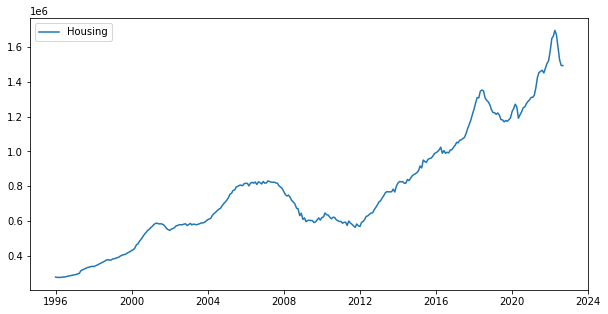

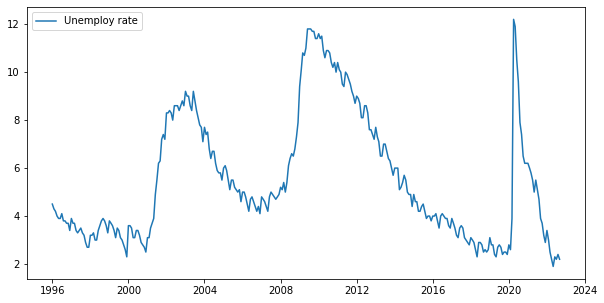

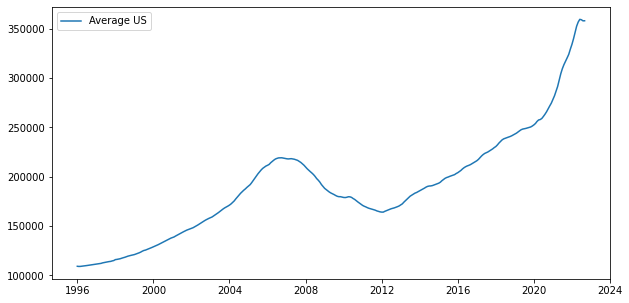

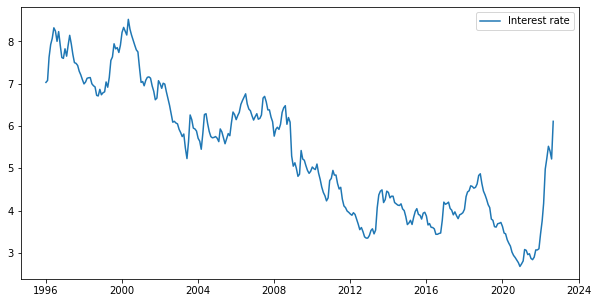

In [ ]:
# apply cointegration test on original data
df3 = {'Housing_Price': data, 'Unemploy_rate': unemploy_data,'US_Prices': dataUS, 'Interest_rate': interest_data}
test_df = pd.DataFrame(data = df3)

cointegration_test(test_df[['Housing_Price','Interest_rate', 'Unemploy_rate', 'US_Prices']])

data_charts(test_df)

---- After smoothing (3-month average) ----
Column Name   >  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Housing_Price >  38.12     > 40.1749   =>   False
Interest_rate >  18.83     > 24.2761   =>   False
Unemploy_rate >  5.68      > 12.3212   =>   False
US_Prices >  0.75      > 4.1296    =>   False


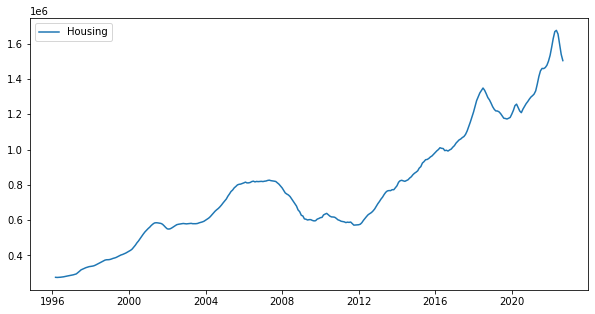

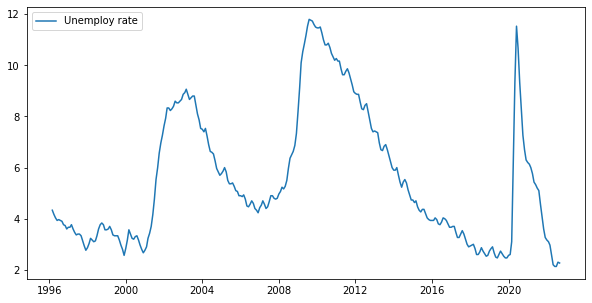

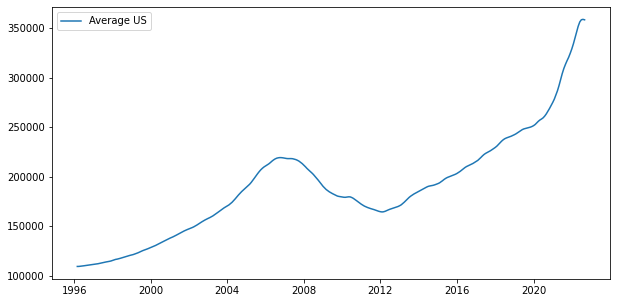

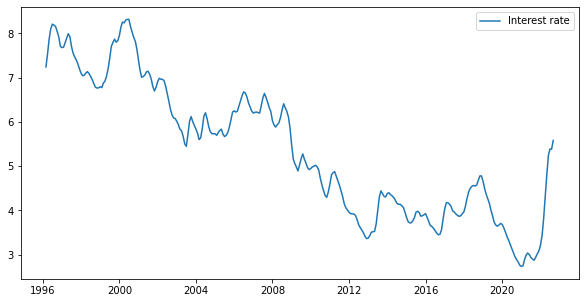

In [ ]:
#perform moving average for 3 month (feature engineering)

print('---- After smoothing (3-month average) ----')
housing_3_average = data.rolling(window=3).mean()[2:]
US_housing_3_average = dataUS.rolling(window=3).mean()[2:]
unemploy_3_average = unemploy_data.rolling(window=3).mean()[2:]
interest_3_average = interest_data.rolling(window=3).mean()[2:]
df4 = {'Housing_Price': housing_3_average, 'Unemploy_rate': unemploy_3_average,'US_Prices': US_housing_3_average, 'Interest_rate': interest_3_average}
test_df2 = pd.DataFrame(data = df4)

cointegration_test(test_df2[['Housing_Price','Interest_rate', 'Unemploy_rate', 'US_Prices']])

data_charts(test_df2)

---- After smoothing (6-month average) ----
Column Name   >  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Housing_Price >  40.71     > 40.1749   =>   True
Interest_rate >  20.39     > 24.2761   =>   False
Unemploy_rate >  3.81      > 12.3212   =>   False
US_Prices >  0.09      > 4.1296    =>   False


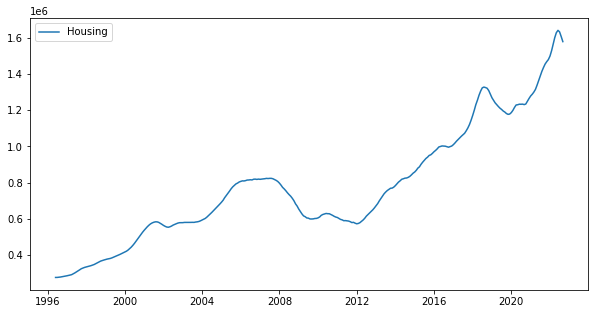

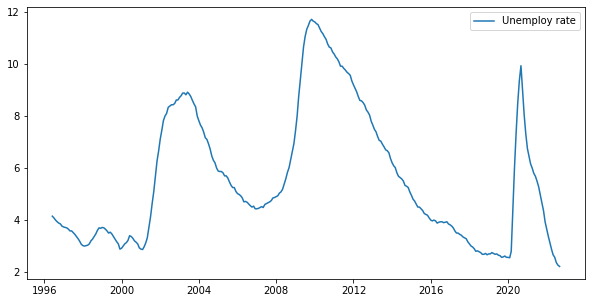

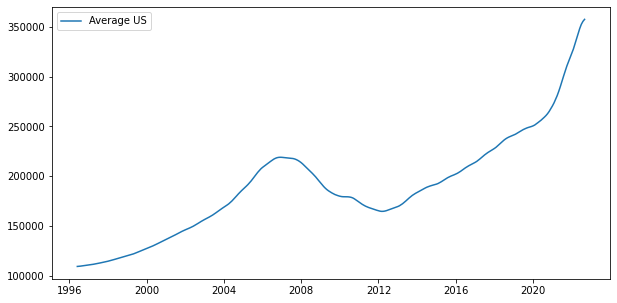

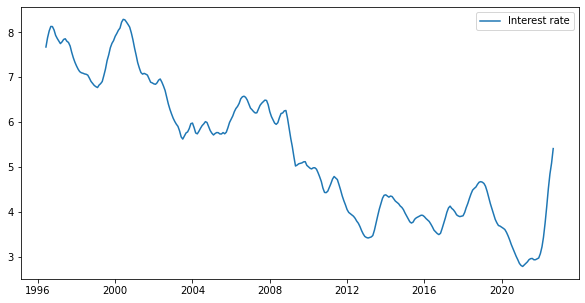

In [ ]:
#perform moving average for 6 months (feature engineering)

print('---- After smoothing (6-month average) ----')
housing_6_average = data.rolling(window=6).mean()[5:]
US_housing_6_average = dataUS.rolling(window=6).mean()[5:]
unemploy_6_average = unemploy_data.rolling(window=6).mean()[5:]
interest_6_average = interest_data.rolling(window=6).mean()[5:]
df5 = {'Housing_Price': housing_6_average, 'Unemploy_rate': unemploy_6_average,'US_Prices': US_housing_6_average, 'Interest_rate': interest_6_average}
test_df3 = pd.DataFrame(data = df5)

cointegration_test(test_df3[['Housing_Price','Interest_rate', 'Unemploy_rate', 'US_Prices']])
data_charts(test_df3)

In [ ]:
# train data contains the prices that are not within the last 30 months
train_data = data.iloc[0:-30]
print(train_data)

# test data contains the prices that are within the last 30 months
test_data = data.iloc[-30:]


1996-01-01    2.768736e+05
1996-02-01    2.747614e+05
1996-03-01    2.750380e+05
1996-04-01    2.746552e+05
1996-05-01    2.762244e+05
                  ...     
2019-11-01    1.181661e+06
2019-12-01    1.192011e+06
2020-01-01    1.228774e+06
2020-02-01    1.246315e+06
2020-03-01    1.270771e+06
Name: 35, Length: 291, dtype: float64


In [ ]:
#Holt Winter’s Exponential Smoothing

from sklearn.model_selection import ParameterGrid
param_grid = {'trend': ['add', 'mul'],'seasonal' :['add', 'mul'],'seasonal_periods':[3,6,12], 
              'smoothing_level': [0.10, 0.20,.30,.40,.50,.60,.70,.80,.90], 
              'smoothing_slope':[0.10, 0.20,.30,.40,.50,.60,.70,.80,.90],
              'damping_slope': [0.10, 0.20,.30,.40,.50,.60,.70,.80,.90],
              'damped' : [False], 'use_boxcox':[False],
             'remove_bias':[True, False],'use_basinhopping':[True, False]}
pg = list(ParameterGrid(param_grid))

In [ ]:
#get the performance of all the combinations of parameters
paramsList = pd.DataFrame(columns=['trend','seasonal_periods','smoothing_level', 
                                   'smoothing_slope','damping_slope','damped','use_boxcox',
                                   'remove_bias','use_basinhopping','RMSE','r2'])
for a,b in enumerate(pg):
    trend = b.get('trend')
    smoothing_level = b.get('smoothing_level')
    seasonal_periods = b.get('seasonal_periods')
    smoothing_level = b.get('smoothing_level')
    smoothing_slope = b.get('smoothing_slope')
    damping_slope = b.get('damping_slope')
    damped = b.get('damped')
    use_boxcox = b.get('use_boxcox')
    remove_bias = b.get('remove_bias')
    use_basinhopping = b.get('use_basinhopping')

    expSmooth = ExponentialSmoothing(train_data,trend=trend, 
                                     damped=damped,
                                     seasonal_periods=seasonal_periods)
    
    model = expSmooth.fit(smoothing_level=smoothing_level, 
                          smoothing_slope=smoothing_slope, 
                          damping_slope = damping_slope,
                          #use_boxcox=use_boxcox,
                          optimized=False)
    
    predict_values = model.forecast(30)

    RMSE = np.sqrt(metrics.mean_squared_error(test_data, predict_values))
    r2 = metrics.r2_score(test_data, predict_values)
    
    # add the RMSE, R2 and the paramaters to the list
    paramsList = paramsList.append({'trend':trend,'seasonal_periods':seasonal_periods,'smoothing_level':smoothing_level, 
                                    'smoothing_slope':smoothing_slope,'damping_slope':damping_slope,'damped':damped,
                                    'use_boxcox':use_boxcox, 'use_basinhopping':use_basinhopping,'RMSE':RMSE,'r2':r2}, ignore_index=True)

In [ ]:
paramsList

,trend,seasonal_periods,smoothing_level,smoothing_slope,damping_slope,damped,use_boxcox,remove_bias,use_basinhopping,RMSE,r2
0,add,3,0.1,0.1,0.1,False,False,NaN,True,259808.436957,-2.061146
1,add,3,0.1,0.1,0.1,False,False,NaN,False,259808.436957,-2.061146
2,mul,3,0.1,0.1,0.1,False,False,NaN,True,252730.874509,-1.896638
3,mul,3,0.1,0.1,0.1,False,False,NaN,False,252730.874509,-1.896638
4,add,3,0.1,0.2,0.1,False,False,NaN,True,461899.354578,-8.675475
...,...,...,...,...,...,...,...,...,...,...,...
34987,mul,12,0.9,0.8,0.9,False,False,NaN,False,335763.143751,-4.112621
34988,add,12,0.9,0.9,0.9,False,False,NaN,True,225405.187387,-1.304122
34989,add,12,0.9,0.9,0.9,False,False,NaN,False,225405.187387,-1.304122
34990,mul,12,0.9,0.9,0.9,False,False,NaN,True,327073.062987,-3.851401


In [ ]:
#sort params
params = paramsList.sort_values(by=['RMSE', 'r2']).iloc[0]
params

trend                        mul
seasonal_periods               3
smoothing_level              0.2
smoothing_slope              0.3
damping_slope                0.1
damped                     False
use_boxcox                 False
remove_bias                  NaN
use_basinhopping            True
RMSE                70339.297443
r2                      0.775625
Name: 46, dtype: object

In [ ]:
#fit into Exponential smoothing model
model1 = ExponentialSmoothing(train_data, trend=params.trend, 
                                         damped=params.damped, 
                                         seasonal_periods= params.seasonal_periods).fit(smoothing_level=params.smoothing_level, 
                                                                                        smoothing_slope=params.smoothing_slope, 
                                                                                        damping_slope=params.damping_slope,
                                                                                        #use_boxcox=params.use_boxcox,
                                                                                        optimized=False)

In [ ]:
#find predicted values
pred_values = model1.forecast(30)

In [ ]:
#calculate MSE, RMSE, R^2
print("MSE: ", metrics.mean_squared_error(test_data, pred_values))
print("RMSE: ", np.sqrt(metrics.mean_squared_error(test_data, pred_values)))
print("R^2: ", metrics.r2_score(test_data, pred_values))

MSE:  4947616764.721986
RMSE:  70339.29744262439
R^2:  0.7756254268391756


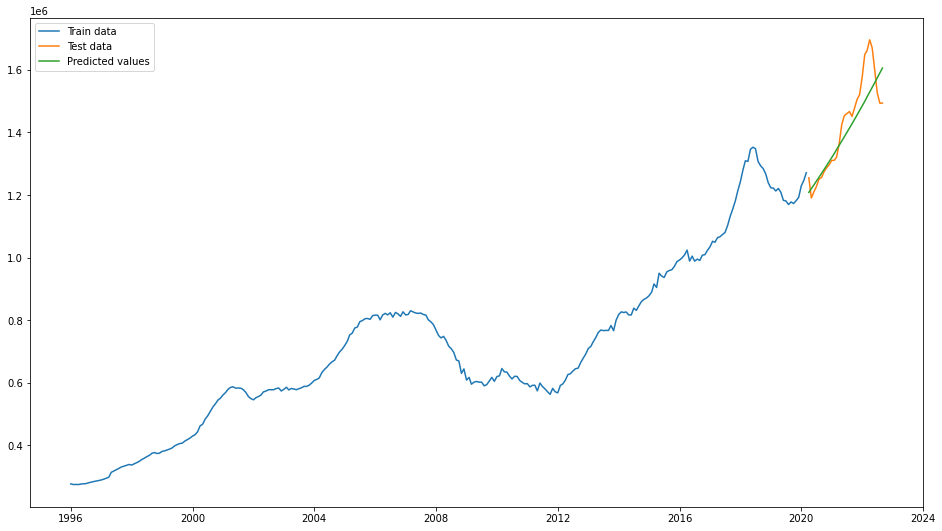

In [ ]:
#visualize the real data and predicted data
%matplotlib inline
plt.rcParams["figure.figsize"] = [16,9]
train_data.index = pd.to_datetime(train_data.index)
test_data.index = pd.to_datetime(test_data.index)
plt.plot(train_data, label="Train data")
plt.plot(test_data, label="Test data")
plt.plot(pred_values, label="Predicted values")
plt.legend(loc='best')


In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


ARIMA with Seasonal value m = 1
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6274.989, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6283.582, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6282.621, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6283.020, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6303.665, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6263.514, Time=0.26 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6270.543, Time=0.21 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=6265.261, Time=0.36 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6264.977, Time=0.36 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6262.957, Time=0.59 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=6267.809, Time=0.20 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=6264.437, Time=0.53 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=6265.971, Time=0.29 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=6266.185, Time=1.00 sec
 

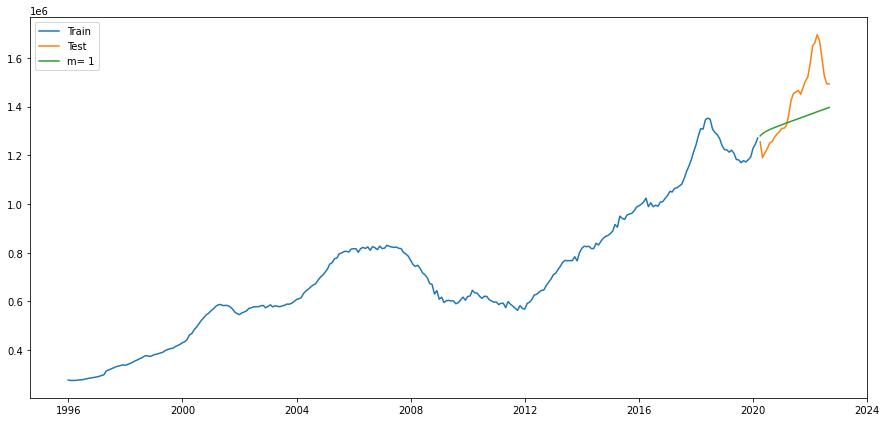

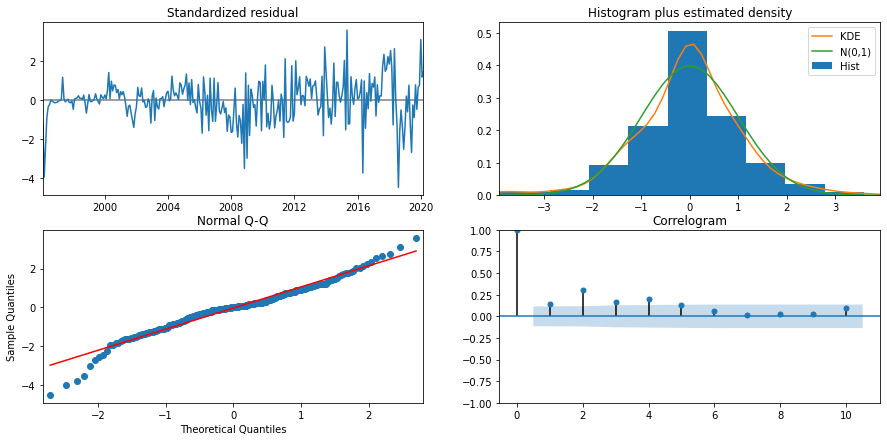

ARIMA with Seasonal value m = 3
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[3]             : AIC=inf, Time=1.75 sec
 ARIMA(0,1,0)(0,1,0)[3]             : AIC=6313.078, Time=0.16 sec
 ARIMA(1,1,0)(1,1,0)[3]             : AIC=6291.881, Time=0.47 sec
 ARIMA(0,1,1)(0,1,1)[3]             : AIC=6286.944, Time=0.48 sec
 ARIMA(0,1,1)(0,1,0)[3]             : AIC=6308.000, Time=0.22 sec
 ARIMA(0,1,1)(1,1,1)[3]             : AIC=inf, Time=2.23 sec
 ARIMA(0,1,1)(0,1,2)[3]             : AIC=6264.217, Time=1.00 sec
 ARIMA(0,1,1)(1,1,2)[3]             : AIC=inf, Time=1.77 sec
 ARIMA(0,1,1)(0,1,3)[3]             : AIC=6257.423, Time=1.29 sec
 ARIMA(0,1,1)(1,1,3)[3]             : AIC=inf, Time=3.35 sec
 ARIMA(0,1,1)(0,1,4)[3]             : AIC=inf, Time=2.27 sec
 ARIMA(0,1,1)(1,1,4)[3]             : AIC=inf, Time=1.85 sec
 ARIMA(0,1,0)(0,1,3)[3]             : AIC=6249.552, Time=1.10 sec
 ARIMA(0,1,0)(0,1,2)[3]             : AIC=6257.474, Time=0.85 sec
 ARIMA(0,1,0)(1,1,3)[3]        

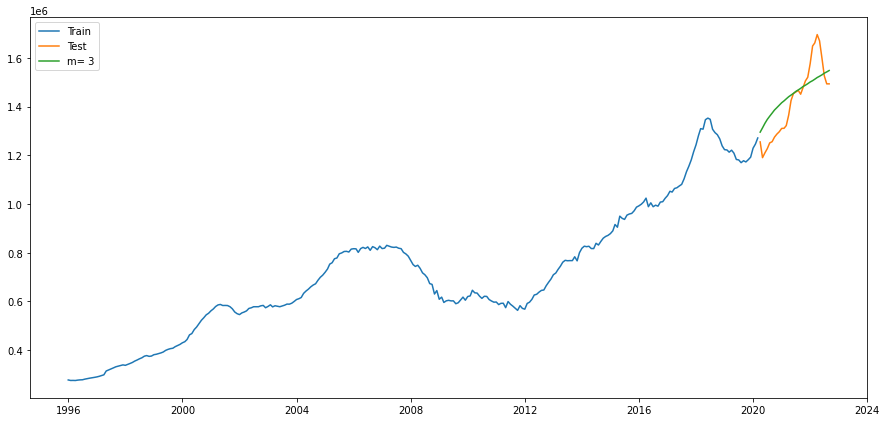

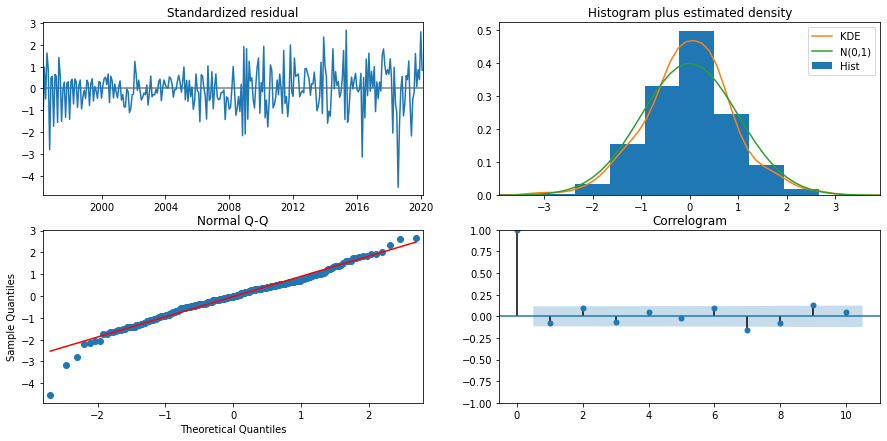

ARIMA with Seasonal value m = 6
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[6]             : AIC=inf, Time=0.64 sec
 ARIMA(0,1,0)(0,1,0)[6]             : AIC=6301.653, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[6]             : AIC=6291.039, Time=0.27 sec
 ARIMA(0,1,1)(0,1,1)[6]             : AIC=6271.779, Time=0.21 sec
 ARIMA(0,1,1)(0,1,0)[6]             : AIC=6303.431, Time=0.09 sec
 ARIMA(0,1,1)(1,1,1)[6]             : AIC=inf, Time=0.43 sec
 ARIMA(0,1,1)(0,1,2)[6]             : AIC=6233.877, Time=1.00 sec
 ARIMA(0,1,1)(1,1,2)[6]             : AIC=6233.284, Time=0.80 sec
 ARIMA(0,1,1)(2,1,2)[6]             : AIC=6231.901, Time=1.16 sec
 ARIMA(0,1,1)(2,1,1)[6]             : AIC=6231.793, Time=0.68 sec
 ARIMA(0,1,1)(2,1,0)[6]             : AIC=6275.404, Time=0.26 sec
 ARIMA(0,1,1)(3,1,1)[6]             : AIC=6231.316, Time=1.29 sec
 ARIMA(0,1,1)(3,1,0)[6]             : AIC=6257.505, Time=0.50 sec
 ARIMA(0,1,1)(4,1,1)[6]             : AIC=6233.146, Time=2.13 sec
 ARIMA(0,1,

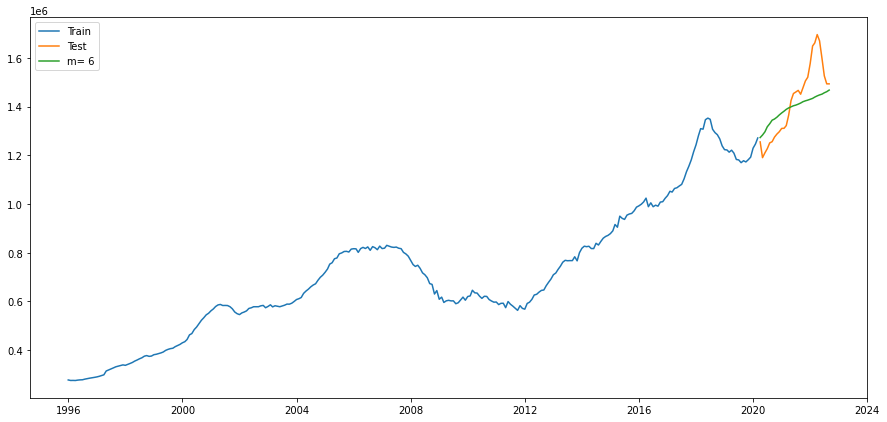

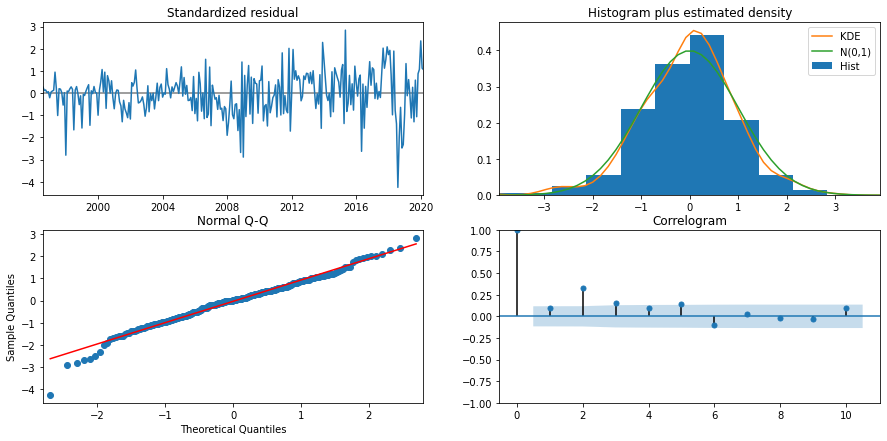

ARIMA with Seasonal value m = 12
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=6143.823, Time=1.02 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=6252.429, Time=0.07 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=6205.453, Time=0.37 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=6169.847, Time=0.62 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=6146.836, Time=0.88 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=6185.577, Time=0.58 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=6144.120, Time=2.87 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=6142.183, Time=2.60 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=6142.604, Time=2.14 sec
 ARIMA(1,1,1)(2,1,2)[12]             : AIC=6143.956, Time=3.14 sec
 ARIMA(1,1,1)(1,1,3)[12]             : AIC=6143.968, Time=7.42 sec
 ARIMA(1,1,1)(0,1,3)[12]             : AIC=6143.563, Time=3.25 sec
 ARIMA(1,1,1)(2,1,3)[12]             : AIC=6145.957, Time=8.78 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=6165.730, 

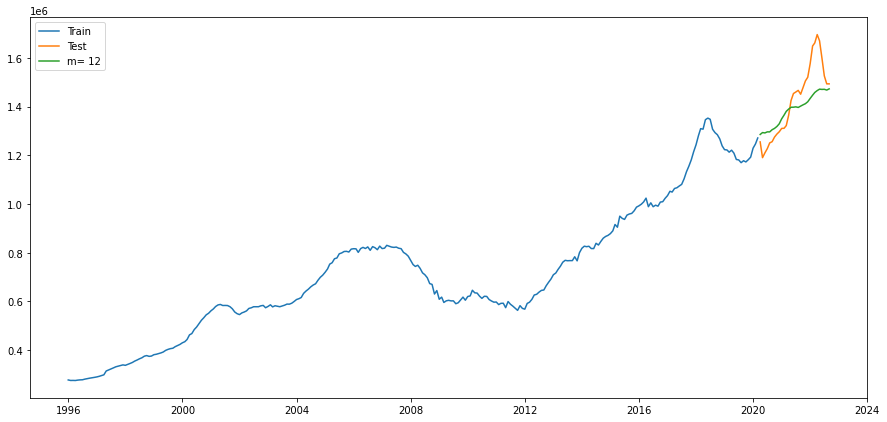

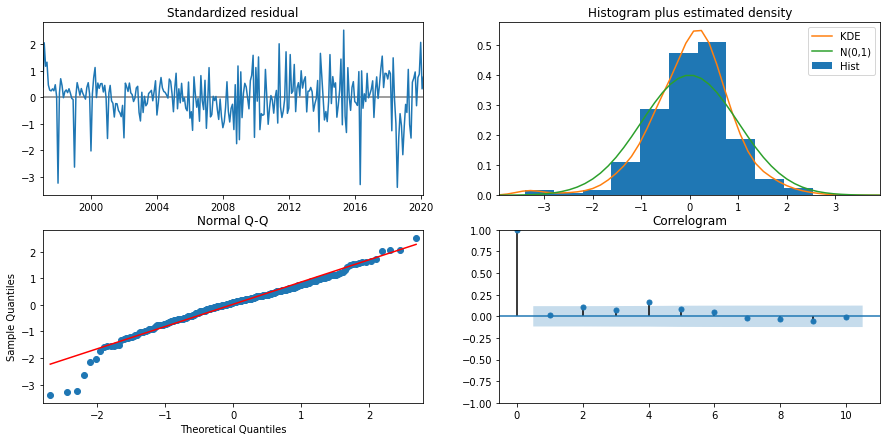

ARIMA with Seasonal value m = 24
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[24]             : AIC=inf, Time=6.61 sec
 ARIMA(0,1,0)(0,1,0)[24]             : AIC=5926.539, Time=0.10 sec
 ARIMA(1,1,0)(1,1,0)[24]             : AIC=5909.031, Time=1.01 sec
 ARIMA(0,1,1)(0,1,1)[24]             : AIC=5890.307, Time=1.43 sec
 ARIMA(0,1,1)(0,1,0)[24]             : AIC=5927.391, Time=0.23 sec
 ARIMA(0,1,1)(1,1,1)[24]             : AIC=inf, Time=2.94 sec
 ARIMA(0,1,1)(0,1,2)[24]             : AIC=inf, Time=6.67 sec
 ARIMA(0,1,1)(1,1,0)[24]             : AIC=5909.271, Time=1.00 sec
 ARIMA(0,1,1)(1,1,2)[24]             : AIC=inf, Time=7.83 sec
 ARIMA(0,1,0)(0,1,1)[24]             : AIC=5892.271, Time=0.85 sec
 ARIMA(1,1,1)(0,1,1)[24]             : AIC=5865.559, Time=2.55 sec
 ARIMA(1,1,1)(0,1,0)[24]             : AIC=5904.952, Time=0.63 sec
 ARIMA(1,1,1)(0,1,2)[24]             : AIC=5851.373, Time=7.54 sec
 ARIMA(1,1,1)(1,1,2)[24]             : AIC=inf, Time=10.75 sec
 ARIMA(1,1

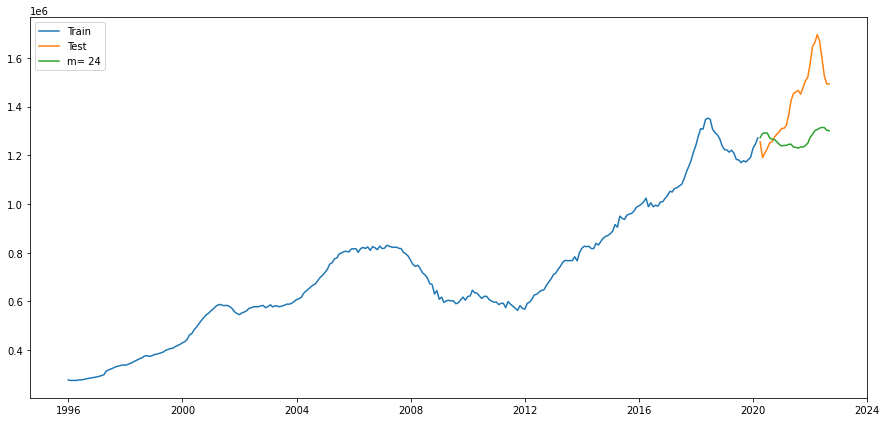

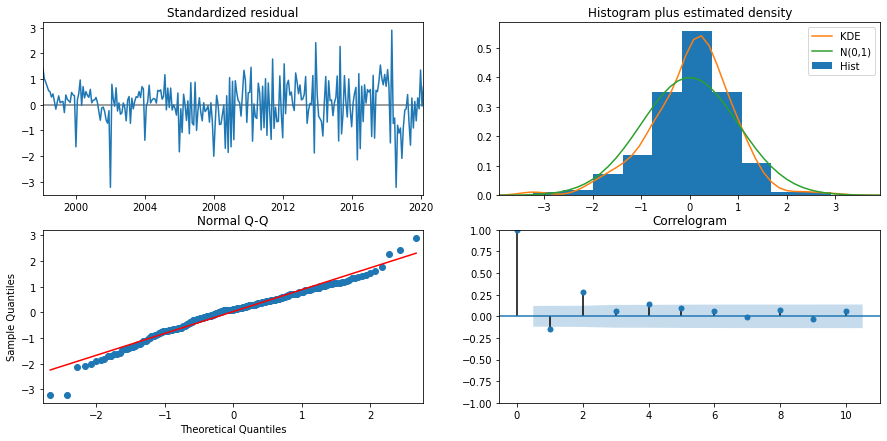

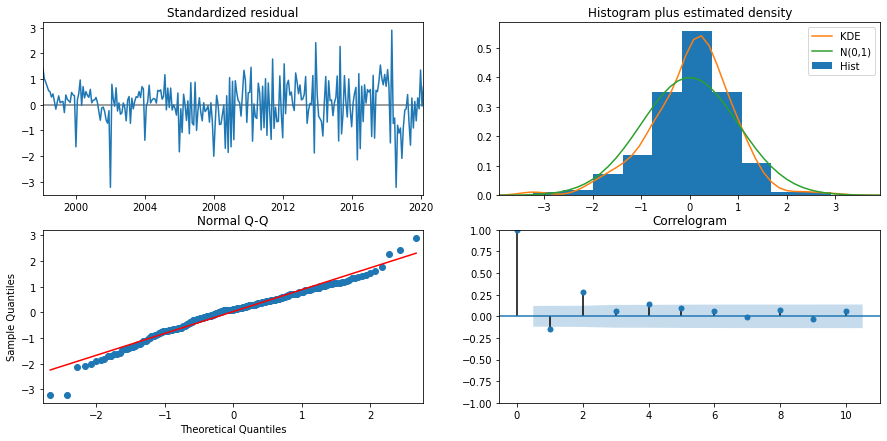

In [ ]:
#get the best model for SARIMA
from pmdarima import auto_arima

for m in [1,3,6,12,24]:
    print('ARIMA with Seasonal value m = '+ str(m))
    model = auto_arima(train_data, start_p=1, start_q=1, max_p=7, max_q=7, 
                       seasonal=True,start_P=1,start_Q=1,max_P=7,max_D=7,max_Q=7, m=m,
                       d=1,D=1, trace=True,error_action='ignore',suppress_warnings=True, stepwise=True) 
    
    predict_values = model.predict(n_periods=30)
    
    timeseries_evaluation_metrics_func(test_data, predict_values)

    %matplotlib inline
    plt.rcParams["figure.figsize"] = [15, 7]
    plt.plot(train_data, label='Train')
    plt.plot(test_data, label='Test')
    plt.plot(predict_values, label='m= ' + str(m))   
    plt.legend(loc='best')
    plt.show()
    
    display(model.plot_diagnostics())


In [ ]:
# Unemployment data
exoX = unemploy_data
exotrain, exotest = exoX[:-30], exoX[-30:]

 Fitting SARIMAX for Seasonal value m = 1
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6274.989, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6283.582, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6282.621, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6283.020, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6303.665, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6263.514, Time=0.46 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6270.543, Time=0.28 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=6265.261, Time=0.61 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6264.977, Time=1.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6262.957, Time=1.28 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=6267.809, Time=0.47 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=6264.437, Time=0.63 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=6265.971, Time=0.44 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=6266.185, Time=

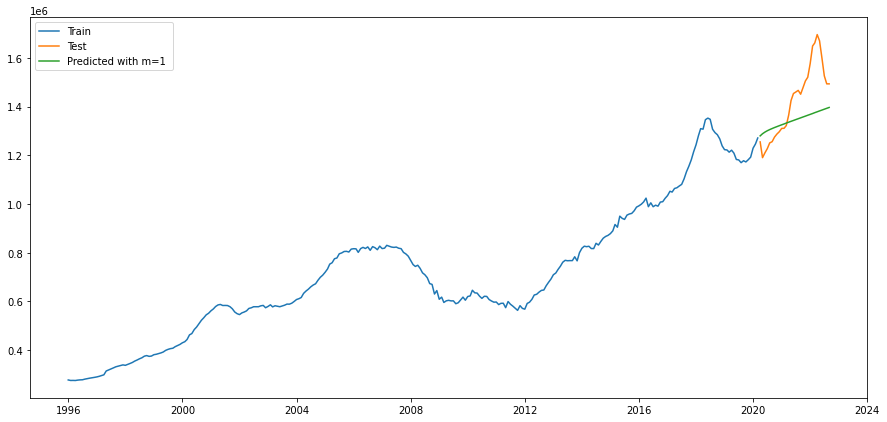

----------------------------------------------------------------------------------------------------
 Diagnostic plot for Seasonal value m = 1


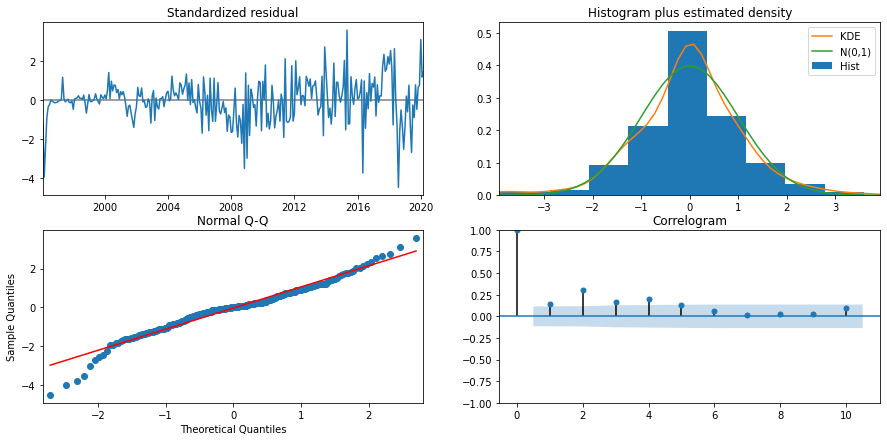

----------------------------------------------------------------------------------------------------
 Fitting SARIMAX for Seasonal value m = 3
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[3]             : AIC=inf, Time=2.28 sec
 ARIMA(0,1,0)(0,1,0)[3]             : AIC=6313.078, Time=0.10 sec
 ARIMA(1,1,0)(1,1,0)[3]             : AIC=6291.881, Time=0.52 sec
 ARIMA(0,1,1)(0,1,1)[3]             : AIC=6286.944, Time=0.64 sec
 ARIMA(0,1,1)(0,1,0)[3]             : AIC=6308.000, Time=0.34 sec
 ARIMA(0,1,1)(1,1,1)[3]             : AIC=inf, Time=2.26 sec
 ARIMA(0,1,1)(0,1,2)[3]             : AIC=6264.217, Time=0.56 sec
 ARIMA(0,1,1)(1,1,2)[3]             : AIC=inf, Time=1.14 sec
 ARIMA(0,1,1)(0,1,3)[3]             : AIC=6257.423, Time=0.90 sec
 ARIMA(0,1,1)(1,1,3)[3]             : AIC=inf, Time=2.00 sec
 ARIMA(0,1,1)(0,1,4)[3]             : AIC=inf, Time=1.64 sec
 ARIMA(0,1,1)(1,1,4)[3]             : AIC=inf, Time=1.02 sec
 ARIMA(0,1,0)(0,1,3)[3]             : AIC=6249.552, 

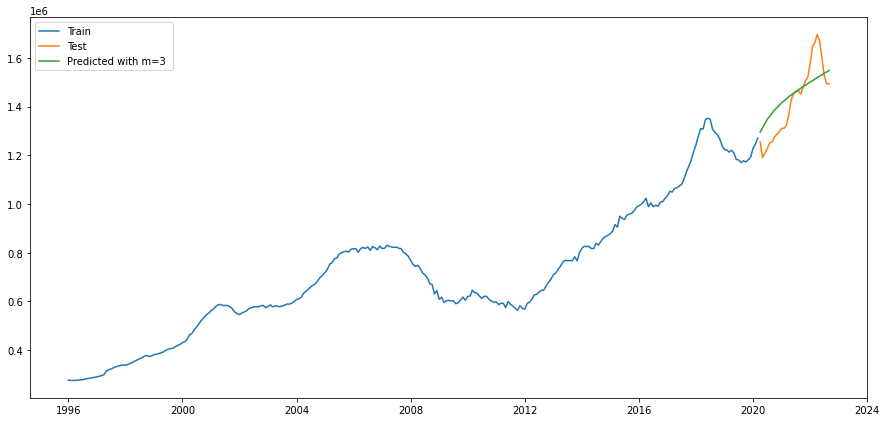

----------------------------------------------------------------------------------------------------
 Diagnostic plot for Seasonal value m = 3


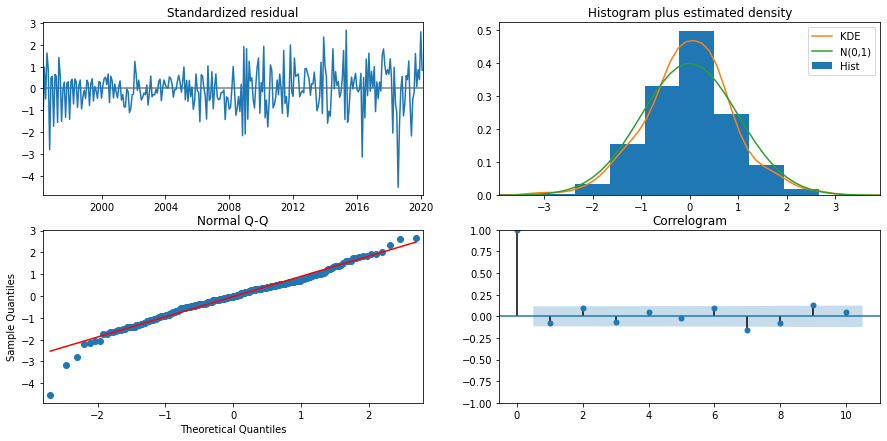

----------------------------------------------------------------------------------------------------
 Fitting SARIMAX for Seasonal value m = 6
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[6]             : AIC=inf, Time=0.56 sec
 ARIMA(0,1,0)(0,1,0)[6]             : AIC=6301.653, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[6]             : AIC=6291.039, Time=0.14 sec
 ARIMA(0,1,1)(0,1,1)[6]             : AIC=6271.779, Time=0.21 sec
 ARIMA(0,1,1)(0,1,0)[6]             : AIC=6303.431, Time=0.08 sec
 ARIMA(0,1,1)(1,1,1)[6]             : AIC=inf, Time=0.42 sec
 ARIMA(0,1,1)(0,1,2)[6]             : AIC=6233.877, Time=0.98 sec
 ARIMA(0,1,1)(1,1,2)[6]             : AIC=6233.284, Time=0.81 sec
 ARIMA(0,1,1)(2,1,2)[6]             : AIC=6231.901, Time=1.11 sec
 ARIMA(0,1,1)(2,1,1)[6]             : AIC=6231.793, Time=0.69 sec
 ARIMA(0,1,1)(2,1,0)[6]             : AIC=6275.404, Time=0.26 sec
 ARIMA(0,1,1)(3,1,1)[6]             : AIC=6231.316, Time=1.26 sec
 ARIMA(0,1,1)(3,1,0)[6]         

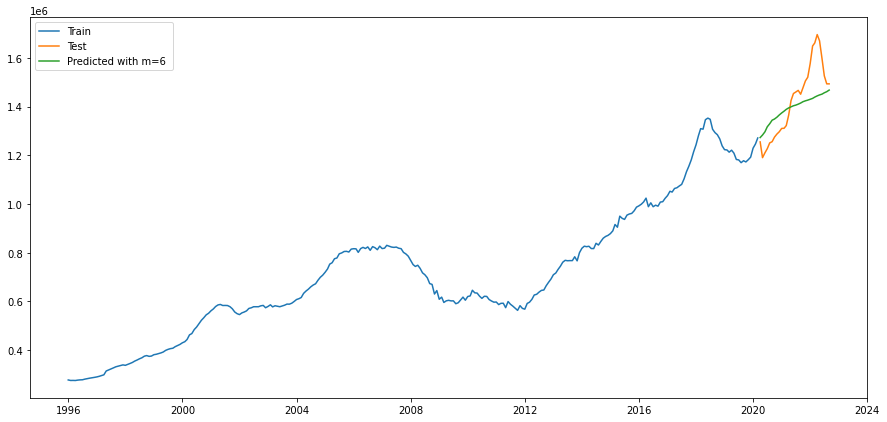

----------------------------------------------------------------------------------------------------
 Diagnostic plot for Seasonal value m = 6


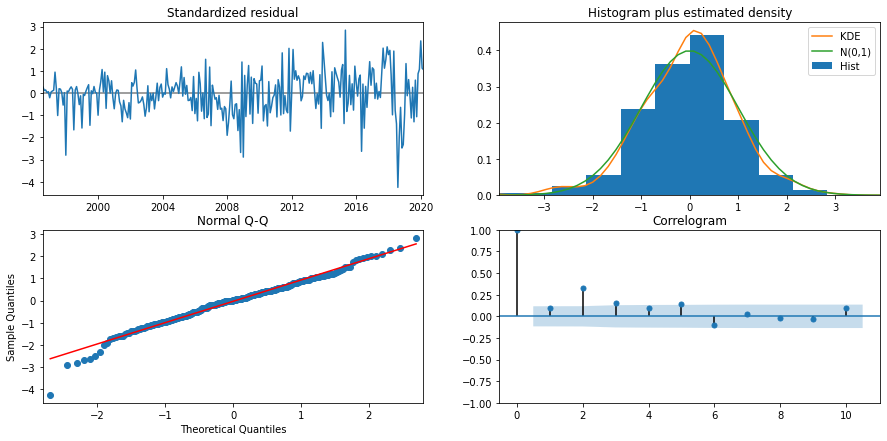

----------------------------------------------------------------------------------------------------
 Fitting SARIMAX for Seasonal value m = 12
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=6143.823, Time=1.03 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=6252.429, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=6205.453, Time=0.38 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=6169.847, Time=0.57 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=6146.836, Time=0.86 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=6185.577, Time=0.55 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=6144.120, Time=2.85 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=6142.183, Time=2.57 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=6142.604, Time=2.12 sec
 ARIMA(1,1,1)(2,1,2)[12]             : AIC=6143.956, Time=4.99 sec
 ARIMA(1,1,1)(1,1,3)[12]             : AIC=6143.968, Time=8.23 sec
 ARIMA(1,1,1)(0,1,3)[12]             : AIC=6143.563, Time=3.26 sec
 ARIMA(1,

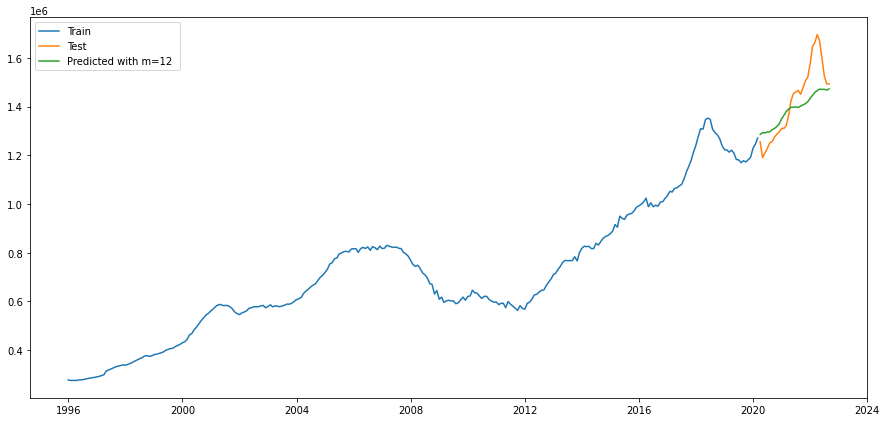

----------------------------------------------------------------------------------------------------
 Diagnostic plot for Seasonal value m = 12


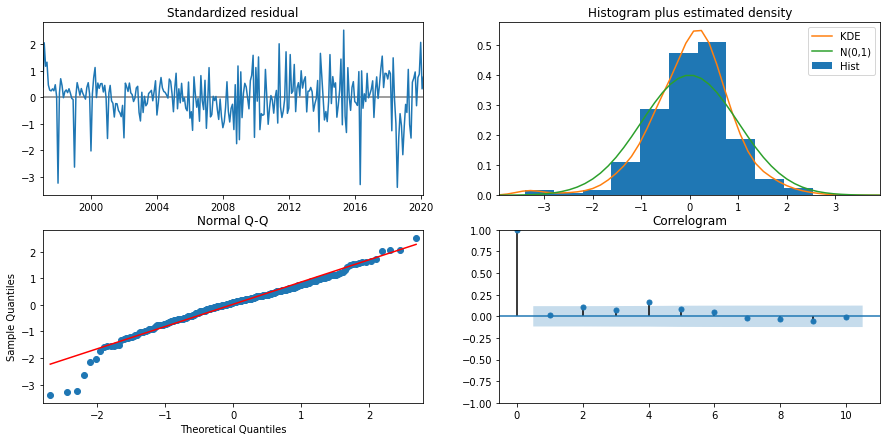

----------------------------------------------------------------------------------------------------
 Fitting SARIMAX for Seasonal value m = 24
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[24]             : AIC=inf, Time=6.61 sec
 ARIMA(0,1,0)(0,1,0)[24]             : AIC=5926.539, Time=0.13 sec
 ARIMA(1,1,0)(1,1,0)[24]             : AIC=5909.031, Time=1.14 sec
 ARIMA(0,1,1)(0,1,1)[24]             : AIC=5890.307, Time=1.50 sec
 ARIMA(0,1,1)(0,1,0)[24]             : AIC=5927.391, Time=0.27 sec
 ARIMA(0,1,1)(1,1,1)[24]             : AIC=inf, Time=2.52 sec
 ARIMA(0,1,1)(0,1,2)[24]             : AIC=inf, Time=4.09 sec
 ARIMA(0,1,1)(1,1,0)[24]             : AIC=5909.271, Time=1.00 sec
 ARIMA(0,1,1)(1,1,2)[24]             : AIC=inf, Time=7.55 sec
 ARIMA(0,1,0)(0,1,1)[24]             : AIC=5892.271, Time=0.81 sec
 ARIMA(1,1,1)(0,1,1)[24]             : AIC=5865.559, Time=2.52 sec
 ARIMA(1,1,1)(0,1,0)[24]             : AIC=5904.952, Time=0.64 sec
 ARIMA(1,1,1)(0,1,2)[24]     

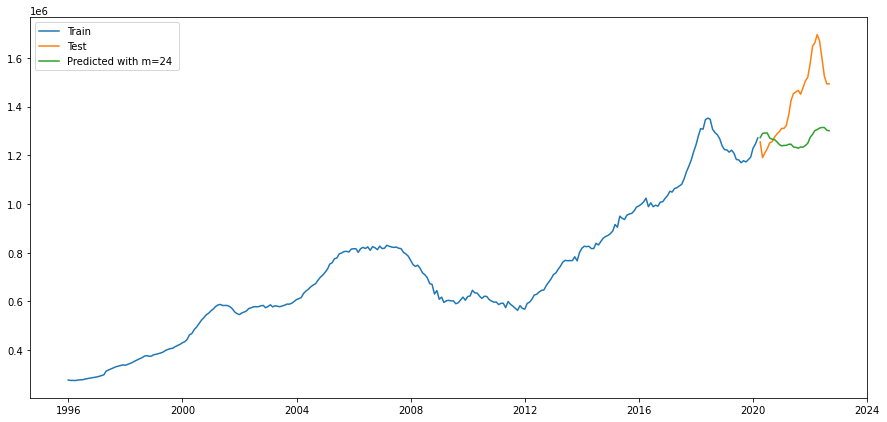

----------------------------------------------------------------------------------------------------
 Diagnostic plot for Seasonal value m = 24


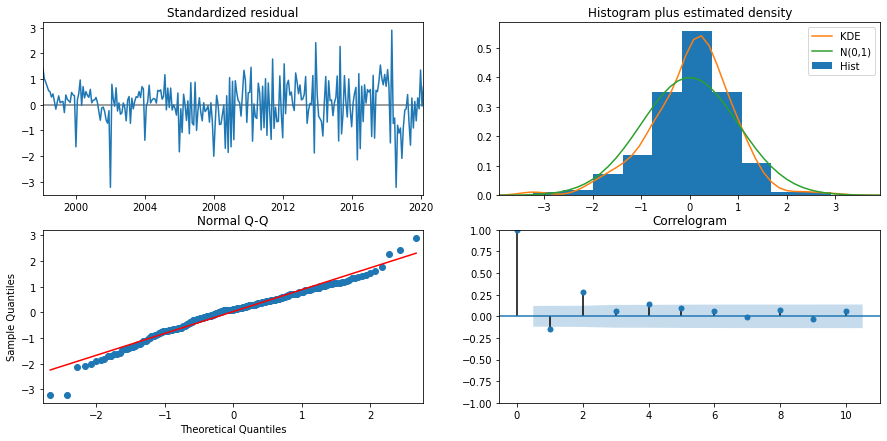

----------------------------------------------------------------------------------------------------


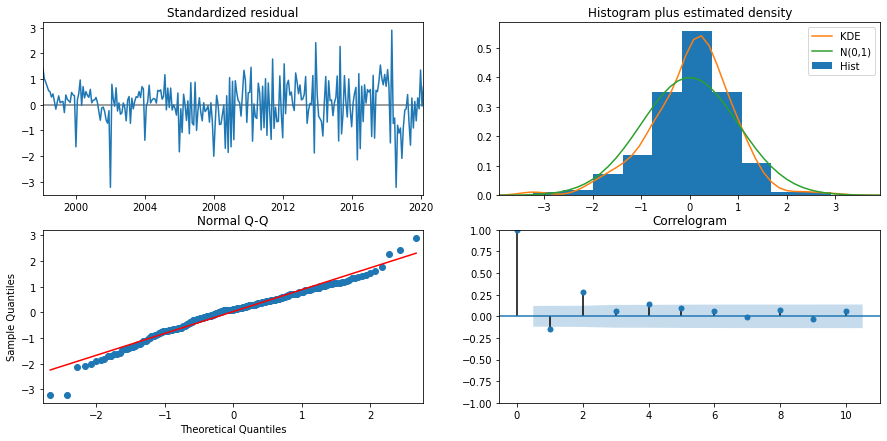

In [ ]:
#get the best model for SARIMAX using unemployment data as exogenous variable
for m in [1,3,6,12,24]:
    print("="*100)
    print(f' Fitting SARIMAX for Seasonal value m = {str(m)}')
    stepwise_model = auto_arima(train_data,exogenous=exotrain,start_p=1,start_q=1,
    max_p=7,max_q=7,seasonal=True,start_P=1,start_Q=1,max_P=7,max_D=7,max_Q=7,m=m,
    d=1,D=1,trace=True,error_action='ignore',suppress_warnings=True,stepwise=True)


    print(f'Model summary for  m = {str(m)}')
    print("-"*100)
    stepwise_model.summary()

    exog_forecast,conf_int = stepwise_model.predict(n_periods=30,exogenous = exotest,return_conf_int=True)

    timeseries_evaluation_metrics_func(test_data, exog_forecast)

    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.rcParams["figure.figsize"] = [15, 7]
    plt.plot(train_data, label='Train ')
    plt.plot(test_data, label='Test ')
    plt.plot(exog_forecast, label=f'Predicted with m={str(m)} ')
    plt.legend(loc='best')
    plt.show()
    print("-"*100)
    print(f' Diagnostic plot for Seasonal value m = {str(m)}')
    
    display(stepwise_model.plot_diagnostics());
    print("-"*100)

In [ ]:
#US prices
exoX = dataUS
exotrain, exotest = exoX[:-30], exoX[-30:]

 Fitting SARIMAX for Seasonal value m = 1
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6274.989, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6283.582, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6282.621, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6283.020, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6303.665, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6263.514, Time=0.21 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6270.543, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=6265.261, Time=0.30 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6264.977, Time=0.31 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6262.957, Time=0.33 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=6267.809, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=6264.437, Time=0.22 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=6265.971, Time=0.15 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=6266.185, Time=

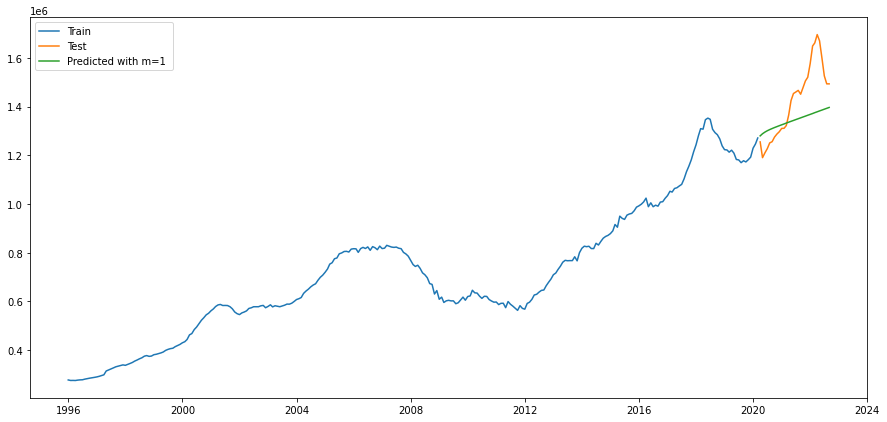

----------------------------------------------------------------------------------------------------
 Diagnostic plot for Seasonal value m = 1


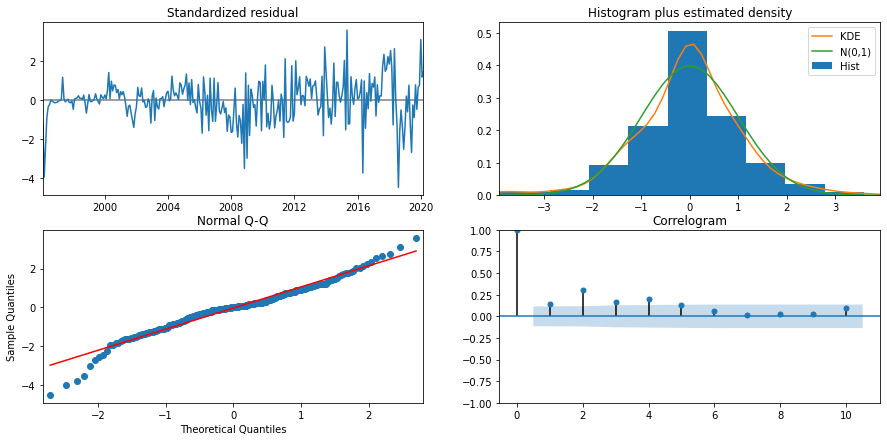

----------------------------------------------------------------------------------------------------
 Fitting SARIMAX for Seasonal value m = 3
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[3]             : AIC=inf, Time=0.54 sec
 ARIMA(0,1,0)(0,1,0)[3]             : AIC=6313.078, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[3]             : AIC=6291.881, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[3]             : AIC=6286.944, Time=0.16 sec
 ARIMA(0,1,1)(0,1,0)[3]             : AIC=6308.000, Time=0.09 sec
 ARIMA(0,1,1)(1,1,1)[3]             : AIC=inf, Time=0.60 sec
 ARIMA(0,1,1)(0,1,2)[3]             : AIC=6264.217, Time=0.28 sec
 ARIMA(0,1,1)(1,1,2)[3]             : AIC=inf, Time=0.51 sec
 ARIMA(0,1,1)(0,1,3)[3]             : AIC=6257.423, Time=0.44 sec
 ARIMA(0,1,1)(1,1,3)[3]             : AIC=inf, Time=0.89 sec
 ARIMA(0,1,1)(0,1,4)[3]             : AIC=inf, Time=0.67 sec
 ARIMA(0,1,1)(1,1,4)[3]             : AIC=inf, Time=0.47 sec
 ARIMA(0,1,0)(0,1,3)[3]             : AIC=6249.552, 

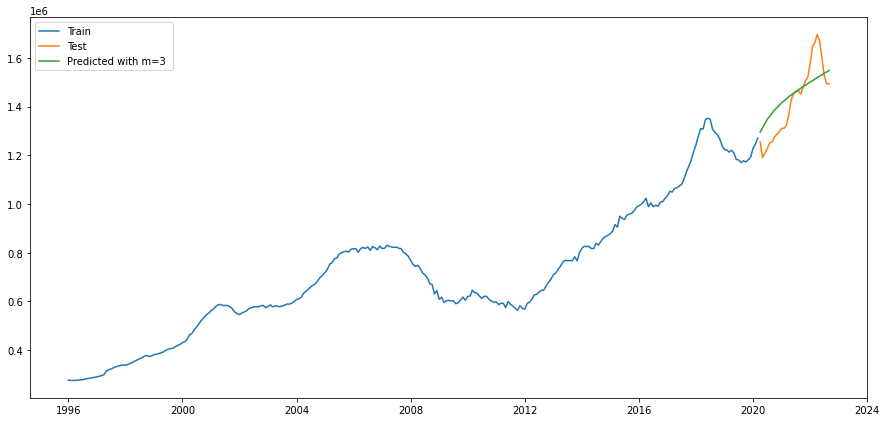

----------------------------------------------------------------------------------------------------
 Diagnostic plot for Seasonal value m = 3


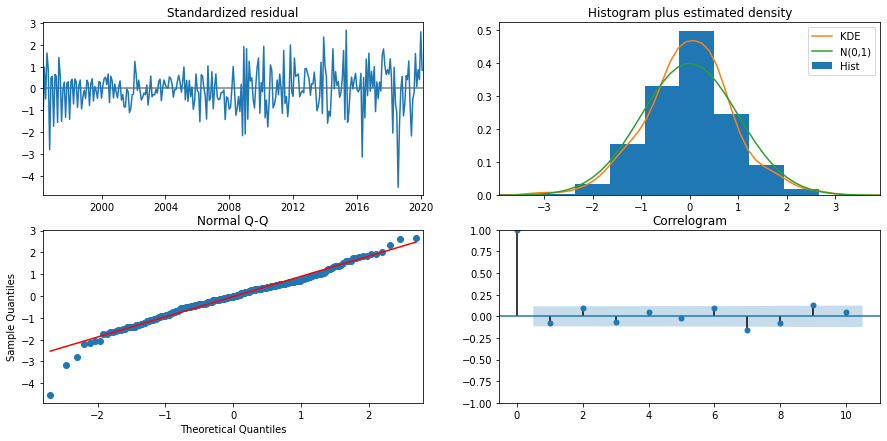

----------------------------------------------------------------------------------------------------
 Fitting SARIMAX for Seasonal value m = 6
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[6]             : AIC=inf, Time=0.61 sec
 ARIMA(0,1,0)(0,1,0)[6]             : AIC=6301.653, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[6]             : AIC=6291.039, Time=0.17 sec
 ARIMA(0,1,1)(0,1,1)[6]             : AIC=6271.779, Time=0.23 sec
 ARIMA(0,1,1)(0,1,0)[6]             : AIC=6303.431, Time=0.08 sec
 ARIMA(0,1,1)(1,1,1)[6]             : AIC=inf, Time=0.45 sec
 ARIMA(0,1,1)(0,1,2)[6]             : AIC=6233.877, Time=1.01 sec
 ARIMA(0,1,1)(1,1,2)[6]             : AIC=6233.284, Time=0.83 sec
 ARIMA(0,1,1)(2,1,2)[6]             : AIC=6231.901, Time=1.14 sec
 ARIMA(0,1,1)(2,1,1)[6]             : AIC=6231.793, Time=0.68 sec
 ARIMA(0,1,1)(2,1,0)[6]             : AIC=6275.404, Time=0.27 sec
 ARIMA(0,1,1)(3,1,1)[6]             : AIC=6231.316, Time=1.26 sec
 ARIMA(0,1,1)(3,1,0)[6]         

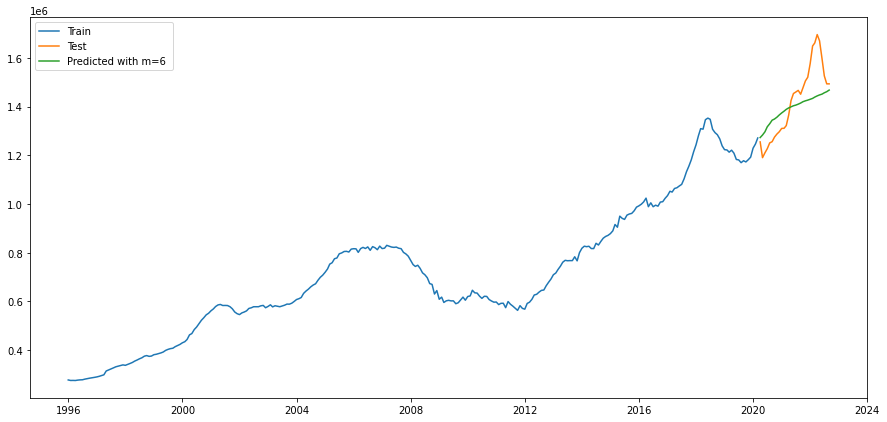

----------------------------------------------------------------------------------------------------
 Diagnostic plot for Seasonal value m = 6


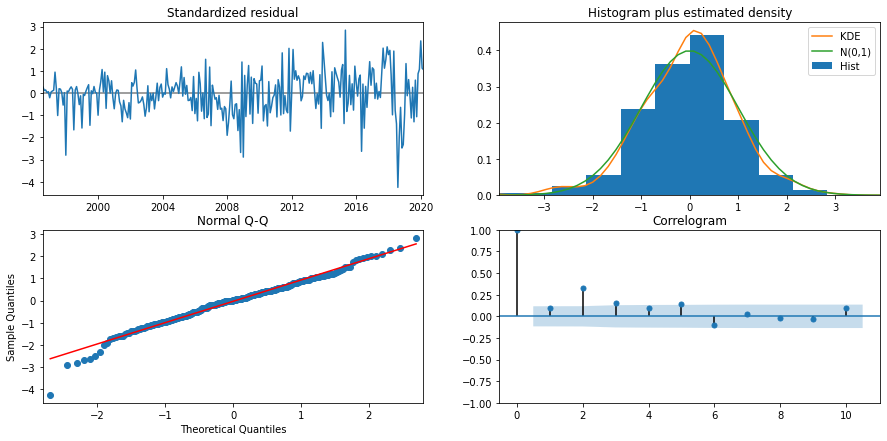

----------------------------------------------------------------------------------------------------
 Fitting SARIMAX for Seasonal value m = 12
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=6143.823, Time=1.06 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=6252.429, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=6205.453, Time=0.39 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=6169.847, Time=0.59 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=6146.836, Time=0.89 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=6185.577, Time=0.56 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=6144.120, Time=2.92 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=6142.183, Time=2.61 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=6142.604, Time=2.20 sec
 ARIMA(1,1,1)(2,1,2)[12]             : AIC=6143.956, Time=3.23 sec
 ARIMA(1,1,1)(1,1,3)[12]             : AIC=6143.968, Time=7.45 sec
 ARIMA(1,1,1)(0,1,3)[12]             : AIC=6143.563, Time=3.17 sec
 ARIMA(1,

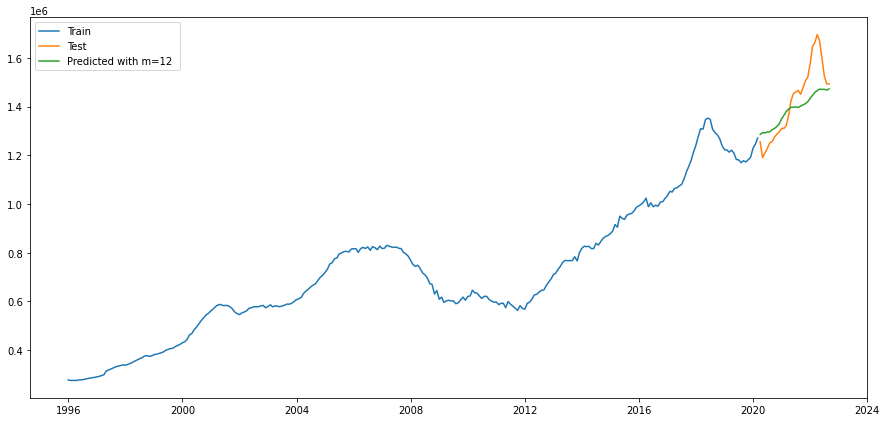

----------------------------------------------------------------------------------------------------
 Diagnostic plot for Seasonal value m = 12


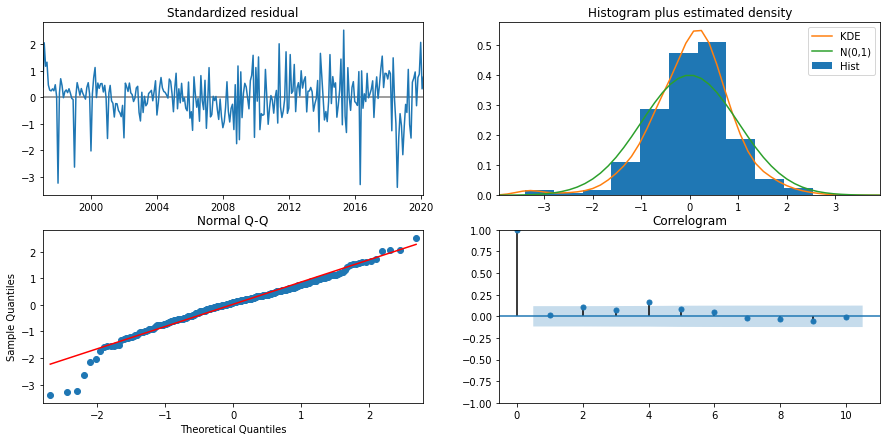

----------------------------------------------------------------------------------------------------
 Fitting SARIMAX for Seasonal value m = 24
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[24]             : AIC=inf, Time=3.86 sec
 ARIMA(0,1,0)(0,1,0)[24]             : AIC=5926.539, Time=0.10 sec
 ARIMA(1,1,0)(1,1,0)[24]             : AIC=5909.031, Time=1.03 sec
 ARIMA(0,1,1)(0,1,1)[24]             : AIC=5890.307, Time=1.51 sec
 ARIMA(0,1,1)(0,1,0)[24]             : AIC=5927.391, Time=0.23 sec
 ARIMA(0,1,1)(1,1,1)[24]             : AIC=inf, Time=2.57 sec
 ARIMA(0,1,1)(0,1,2)[24]             : AIC=inf, Time=4.19 sec
 ARIMA(0,1,1)(1,1,0)[24]             : AIC=5909.271, Time=0.99 sec
 ARIMA(0,1,1)(1,1,2)[24]             : AIC=inf, Time=7.94 sec
 ARIMA(0,1,0)(0,1,1)[24]             : AIC=5892.271, Time=0.85 sec
 ARIMA(1,1,1)(0,1,1)[24]             : AIC=5865.559, Time=2.62 sec
 ARIMA(1,1,1)(0,1,0)[24]             : AIC=5904.952, Time=0.65 sec
 ARIMA(1,1,1)(0,1,2)[24]     

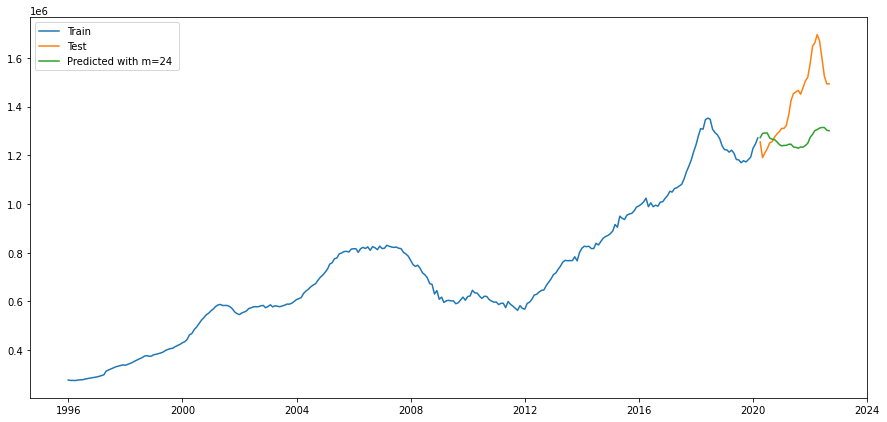

----------------------------------------------------------------------------------------------------
 Diagnostic plot for Seasonal value m = 24


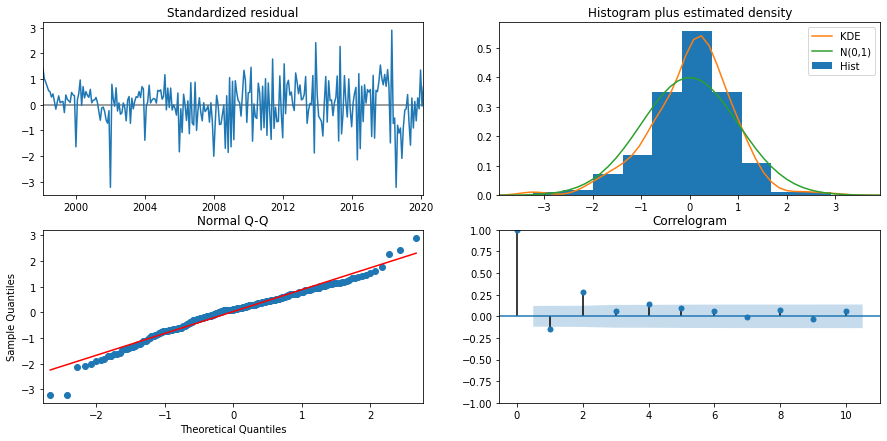

----------------------------------------------------------------------------------------------------


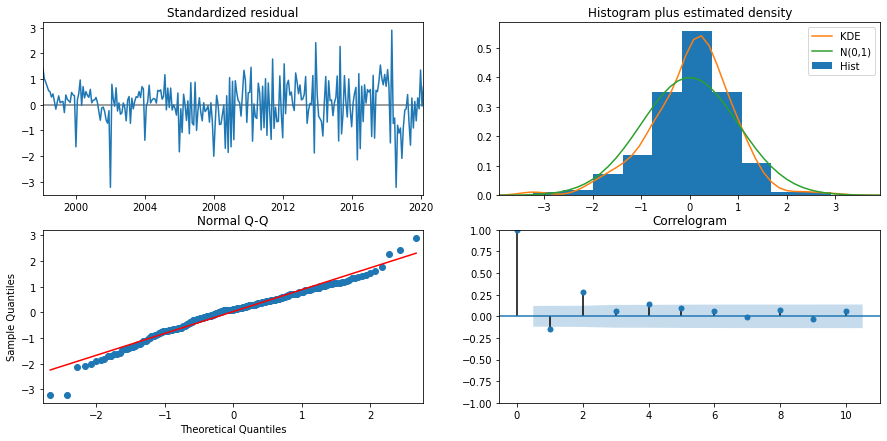

In [ ]:
#get the best model for SARIMAX using US housing price data as exogenous variable

for m in [1,3,6,12,24]:
    print("="*100)
    print(f' Fitting SARIMAX for Seasonal value m = {str(m)}')
    stepwise_model = auto_arima(train_data,exogenous=exotrain,start_p=1,start_q=1,
    max_p=7,max_q=7,seasonal=True,start_P=1,start_Q=1,max_P=7,max_D=7,max_Q=7,m=m,
    d=1,D=1,trace=True,error_action='ignore',suppress_warnings=True,stepwise=True)


    print(f'Model summary for  m = {str(m)}')
    print("-"*100)
    stepwise_model.summary()

    exog_forecast,conf_int = stepwise_model.predict(n_periods=30,exogenous = exotest,return_conf_int=True)

    timeseries_evaluation_metrics_func(test_data, exog_forecast)

    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.rcParams["figure.figsize"] = [15, 7]
    plt.plot(train_data, label='Train ')
    plt.plot(test_data, label='Test ')
    plt.plot(exog_forecast, label=f'Predicted with m={str(m)} ')
    plt.legend(loc='best')
    plt.show()
    print("-"*100)
    print(f' Diagnostic plot for Seasonal value m = {str(m)}')
    
    display(stepwise_model.plot_diagnostics());
    print("-"*100)

In [ ]:
#ARIMA(2,1,1)(0,1,2)[12] 
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(data, order = (2,1,1), seasonal_order = (0,1,2,12), trend = 'ct',intercept = False, enforce_stationarity = False) 

sarima_results =  model.fit()

sarima_results_summary = sarima_results.summary()

print(sarima_results_summary)

                                        SARIMAX Results                                        
Dep. Variable:                                      35   No. Observations:                  321
Model:             SARIMAX(2, 1, 1)x(0, 1, [1, 2], 12)   Log Likelihood               -3148.836
Date:                                 Fri, 09 Dec 2022   AIC                           6313.672
Time:                                         21:16:37   BIC                           6342.808
Sample:                                     01-01-1996   HQIC                          6325.356
                                          - 09-01-2022                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    192.2705   1727.808      0.111      0.911   -3194.171    3578

In [ ]:
#Find the future forecast of 12 months
nforecast = 11
one_step_forecast = sarima_results.get_prediction(end = model.nobs + nforecast)

df_fcst_12_month = one_step_forecast.predicted_mean
df_fcst_12_month_df = pd.DataFrame(df_fcst_12_month)
print(df_fcst_12_month_df.tail(12))

            predicted_mean
2022-10-01    1.484966e+06
2022-11-01    1.485203e+06
2022-12-01    1.483504e+06
2023-01-01    1.496903e+06
2023-02-01    1.504437e+06
2023-03-01    1.515334e+06
2023-04-01    1.525510e+06
2023-05-01    1.523792e+06
2023-06-01    1.535065e+06
2023-07-01    1.541844e+06
2023-08-01    1.545541e+06
2023-09-01    1.542559e+06


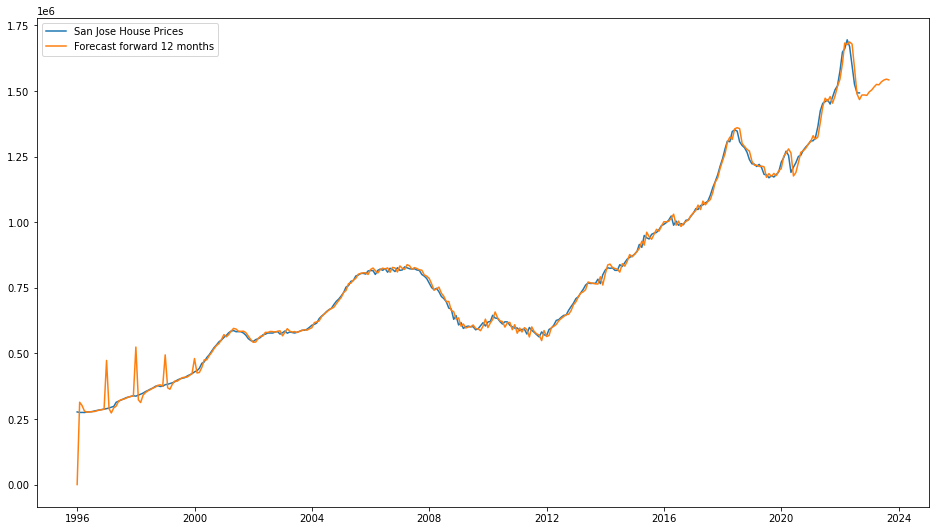

In [ ]:
#plot the future forecast
%matplotlib inline
plt.rcParams["figure.figsize"] = [16, 9]
plt.plot(data, label='San Jose House Prices')
plt.plot(df_fcst_12_month_df, label = 'Forecast forward 12 months')

plt.legend(loc='best')
plt.show()